# IMMC 2020
### Importing Modules and Data

In [1]:
import pandas as pd
import copy
import re
import random
import math, statistics
import gc
import matplotlib.pyplot as plt
from pprint import pprint

median_income = 9733/365
loss_aversion_coefficient = 2
max_shelf_capacity = 100

pdt_csv_data = pd.read_csv("StoreData_IMMC_CSV.csv")
print(pdt_csv_data.head())

          department product_category       product_type     brand  \
0    TV&Home Theater   TVS 30" to 45"    1080p LED Smart  Brand BB   
1  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand A   
2  Computers&Tablets          Laptops  2-in-1 Chromebook  Brand BB   
3  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand G   
4  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand P   

                                                name  initial_price  \
0                 40" 1080p Smart LED HDTV, 5 Series         259.99   
1  2-in-1 11.6" Touch-Screen Chromebook, Intel Ce...         279.99   
2  2-in-1 12.2" Touch-Screen Chromebook, Intel Ce...         449.00   
3  2-in-1 14" Touch-Screen Chromebook, Intel Core...         549.00   
4  2-in-1 14" Touch-Screen Chromebook, Intel Core...         599.00   

   discounted_price  qty  customer_rating  brand_rating  percentage_usage  \
0            179.99    8              4.7      4.623810              0.95  

In [2]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

## Determining the Popularity of Product
### Impact of Discount on Popularity

In [3]:
# Traditional Econs Approach
def q1_over_q0(p0, p1, percentage_usage):
    x = (p0 - p1)*(percentage_usage/median_income) 
    return (math.exp(x))

# Behavioural Econs Approach
def prospect_utility(x):
    if x > 0:
        return(math.log(x+1))
    else:
        return(-loss_aversion_coefficient * math.log(-x + 1))

def increase_utility(p0, p1):
    return(prospect_utility(p0 - p1))

# Helper Variables
max_increase_utility = increase_utility(3329.99, 2199.99)
min_increase_utility = 0
max_q1_over_q0 = q1_over_q0(3329.99, 2199.99, 1)
min_q1_over_qo = 1

# Combined Effect [Between 0 and 1]
def popularity_due_to_discount(p0, p1, percentage_usage):
    traditional_econs_adjusted = (q1_over_q0(p0, p1, percentage_usage)-min_q1_over_qo)/max_q1_over_q0
    behavioural_econs_adjusted = (increase_utility(p0, p1)-min_increase_utility)/max_increase_utility

    total_adjusted = statistics.mean([traditional_econs_adjusted, behavioural_econs_adjusted])
    return(total_adjusted)

### Effect of Loss Adversion on Popularity

In [4]:
# [Between 0 and 1]
def popularity_due_to_loss_aversion(qty):
    return(math.exp(-qty/loss_aversion_coefficient))

### Effects of Saliency Bias on Popularity (TO DO)

In [5]:
def popularity_due_to_saliency_bias(size, qty):
    return sigmoid(size*qty)

### Effects of Ratings on Popularity

In [6]:
# [Between 0 and 1]
def popularity_due_to_rating(pdt_rating, brand_rating):
    raw_brand = (0.8*pdt_rating + 0.2*brand_rating)
    return(raw_brand/5)

## Creating Product Class and List

In [7]:
pdt_list = []
class product:
    # Popularity Coefficients
    pop_loss_adversion_coefficient = 0.33
    pop_saliency_coefficient = 0.33
    pop_rating_coefficient = 0.33
    
    
    # Raw Data
    def __init__(self, index, name, department, product_category, product_type, brand, initial_price, discounted_price, qty, customer_rating, brand_rating=5, percentage_usage=0.5, size=20):
        self.name = name
        self.index = index
        self.department = department
        self.product_category = product_category
        self.product_type = product_type
        self.brand = brand
        self.initial_price = initial_price
        self.discounted_price = discounted_price
        self.qty = qty
        self.customer_rating = customer_rating
        self.brand_rating = brand_rating
        self.percentage_usage = percentage_usage
        self.size = size
        
        self.popularity = 0
    
    # Processed Data
    
    def set_popularity(self):
        discount_factor = popularity_due_to_discount(self.initial_price, self.discounted_price, self.percentage_usage)
        loss_adversion_factor = popularity_due_to_loss_aversion(self.qty)
        saliency_factor = popularity_due_to_saliency_bias(self.size, self.qty)
        rating_factor = popularity_due_to_rating(self.customer_rating, self.brand_rating)
        
        initial_popularity = self.pop_loss_adversion_coefficient*loss_adversion_factor + self.pop_saliency_coefficient*saliency_factor + self.pop_rating_coefficient*rating_factor
        self.popularity = sigmoid(initial_popularity + discount_factor)
        
        
        

In [8]:
# Populating the Product List
for index, row in pdt_csv_data.iterrows():
    
    total_qty = row["qty"]
    unit_size = row["index_size"] # TO CHANGE
    while True:
        cur_qty = min(int(max_shelf_capacity/unit_size), total_qty)
        total_qty -= cur_qty
        
        #print(cur_qty)
        
        cur_pdt = product(index, row["name"], row["department"], row["product_category"], row["product_type"], row["brand"], row["initial_price"], row["discounted_price"], cur_qty, row["customer_rating"], size=unit_size, brand_rating=row["brand_rating"], percentage_usage=row["percentage_usage"])
        cur_pdt.set_popularity()
        
        if total_qty <=0:
            break
    
    pdt_list.append(cur_pdt)


In [9]:
pdt_list[4].index

4

## Creating Shelf Class and Layout Object

In [10]:
class shelf:
    # Class Variables
    max_capacity = 100
    
    def __init__(self):
        self.pdts = []
        self.pdt_set = set()
        self.cur_capacity = 0
    
    def add_pdt(self, pdt):
        # If shelf can accomodate the product
        if self.cur_capacity + pdt.size <= self.max_capacity:
            self.cur_capacity += pdt.size
            self.pdts.append(pdt)
            self.pdt_set.add(pdt.index)
            return 0
        
        # If shelf is full
        return -1

In [19]:
class layout:
    
    def __init__(self, grid, counter, entrance, exit, shelf_list=[], pdt_list=[]):
        self.counter = counter
        self.value_of_goods_bought = 0
        self.entrance = entrance
        self.exit = exit
        
        # Grid is a 2d matrix where shelves are 1 indexed
        self.grid = copy.deepcopy(grid)
        self.shelf_list = copy.deepcopy(shelf_list)
        
        # A* Grid is a grid where shelves are labelled as 1
        self.a_star_grid = copy.deepcopy(grid)
        for i in range(len(self.a_star_grid)):
            for j in range(len(self.a_star_grid)):
                if self.a_star_grid[i][j] > 1:
                    self.a_star_grid[i][j] = 1
                    
        # Shopper Density Grid is a grid to record the density of shoppers; shelves have a density of 99
        self.shopper_density_grid = copy.deepcopy(self.a_star_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                if self.shopper_density_grid[i][j] == 1:
                    self.shopper_density_grid[i][j] = -1
                    
        # Price Density Grid is a grid to record to value of products the customers are carrying at particular locations
        self.price_density_grid = copy.deepcopy(grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                if self.price_density_grid[i][j] > 0:
                    self.price_density_grid[i][j] = 0
                    
                    
        # pdt_list contains the products that exists somewhere within the layout
        self.pdt_list = copy.deepcopy(pdt_list)
        
        
        
    # A_Star Performs a simulation of a person walking within the layout from init to goal
    # A_Star Returns a list of nodes visited on the path
    # Coordinates are written as [y,x] with [0,0] being the upper left hand corner
    def a_star(self, init, goal): 
        grid = copy.deepcopy(self.a_star_grid)
        
        # init = [0, 0]
        # goal = [len(grid) - 1, len(grid[0]) - 1]  # all coordinates are given in format [y,x]
        
        cost = 1

        # the cost map which pushes the path closer to the goal
#         heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
#         for i in range(len(grid)):
#             for j in range(len(grid[0])):
#                 heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
#                 if grid[i][j] == 1:
#                     heuristic[i][j] = 99  # added extra penalty in the heuristic map

        heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
                if grid[i][j] == 1:
                    heuristic[i][j] = 999999  # added extra penalty in the heuristic map
                else:
                    heuristic[i][j] = self.shopper_density_grid[i][j]



        # the actions we can take
        delta = [[-1, 0], [0, -1], [1, 0], [0, 1]]  # go up  # go left  # go down  # go right


        # function to search the path
        def search(grid, init, goal, cost, heuristic):

            closed = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the reference grid
            closed[init[0]][init[1]] = 1
            action = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the action grid

            x = init[0]
            y = init[1]
            g = 0
            f = g + heuristic[init[0]][init[0]]
            cell = [[f, g, x, y]]

            found = False  # flag that is set when search is complete
            resign = False  # flag set if we can't find expand

            while not found and not resign:
                if len(cell) == 0:
                    return "FAIL"
                else:
                    cell.sort()  # to choose the least costliest action so as to move closer to the goal
                    cell.reverse()
                    next = cell.pop()
                    x = next[2]
                    y = next[3]
                    g = next[1]

                    if x == goal[0] and y == goal[1]:
                        found = True
                    else:
                        for i in range(len(delta)):  # to try out different valid actions
                            x2 = x + delta[i][0]
                            y2 = y + delta[i][1]
                            if x2 >= 0 and x2 < len(grid) and y2 >= 0 and y2 < len(grid[0]):
                                if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                                    g2 = g + cost
                                    f2 = g2 + heuristic[x2][y2]
                                    cell.append([f2, g2, x2, y2])
                                    closed[x2][y2] = 1
                                    action[x2][y2] = i
            invpath = []
            x = goal[0]
            y = goal[1]
            invpath.append([x, y])  # we get the reverse path from here
            while x != init[0] or y != init[1]:
                x2 = x - delta[action[x][y]][0]
                y2 = y - delta[action[x][y]][1]
                x = x2
                y = y2
                invpath.append([x, y])

            path = []
            for i in range(len(invpath)):
                path.append(invpath[len(invpath) - 1 - i])
                
#             print("ACTION MAP")
#             for i in range(len(action)):
#                 print(action[i])

            return path
        return search(grid, init, goal, cost, heuristic)
    
    # Simulates Choice of Object to Buy and Deletes that Object from Object List
    def choose_pdt(self):
        #print("pdt list len", len(self.pdt_list))
        if len(self.pdt_list) == 0:
            print("RAN OUT OF ITEMS IN SHOP")
            return -1
        self.pdt_list.sort(key=lambda x: x.popularity, reverse=True)
        index = min(random.randint(0, 5), len(self.pdt_list) -1)
        chosen_pdt = copy.deepcopy(self.pdt_list[index])
        return chosen_pdt
    
    def delete_pdt(self, product_index):
        for i in range(len(self.pdt_list)):
            if self.pdt_list[i].index == product_index:
                # print("deleting pdt from list", product_index)
                
                if self.pdt_list[i].qty == 1:
                    self.pdt_list.pop(i)
                else:
                    self.pdt_list[i].qty -= 1
                    
                break
        
        return
    
    # Find Product in Sheleves
    def find_shelf(self, chosen_pdt_index):
        for shelf_index, shelf in enumerate(self.shelf_list):
                # print("Checking shelf", shelf_index)
                if chosen_pdt_index in shelf.pdt_set:
                    chosen_shelf_index = shelf_index
        return chosen_shelf_index
    
    def delete_pdt_from_shelf(self, chosen_pdt_index, shelf_index):
        # Remove product from shelf
        shelf = self.shelf_list[shelf_index]
        for i in range(len(shelf.pdts)):
            if shelf.pdts[i].index == chosen_pdt_index:
                # print("QTY of pdt", shelf.pdts[i].qty)
                    if shelf.pdts[i].qty <= 1:
                        print("ran out of product", chosen_pdt_index)
                        del shelf.pdts[i]
                        shelf.pdt_set.discard(chosen_pdt_index)
                    else:
                        shelf.pdts[i].qty-= 1
                    break
                        
        
    def walk(self, init, goal, cur_size, cur_price):
        # Conduct A*
        delta = [(1,0), (-1,0), (0,1), (0,-1)]
        for d in delta:
            y = goal[0]+d[0]
            x = goal[1]+d[1]
            if x >= 0 and x < len(self.grid) and y >= 0 and y < len(self.grid[0]):
                if goal == self.exit:
                    [y,x] = [goal[0], goal[1]]
                path = self.a_star(init, [y,x])
                # print("init", init)
                # print("goal", [y,x])
                if path == "FAIL":
                    z=0
                    #print("FAILURE TO REACH SHELF by going to ", [y,x])
                else:
                    for cell in path:
                        #print("walked", cur_size)
                        self.shopper_density_grid[cell[0]][cell[1]] += cur_size
                        self.price_density_grid[cell[0]][cell[1]] += cur_price
                    cur_pos = [y,x]
                    print("Visited ", y, x)
                    return cur_pos
        
    # Simulates a person entering shop
    def new_shopper(self):
        print("--Testing New Shopper--")
        max_number_of_products = 3
        max_size = 300
        
        cur_number_of_pdt = 0
        cur_size = random.randint(40, 60)
        cur_price = 0
        
        print("Size of Shopper:", cur_size)
        
        # Random Entrance Square
        cur_pos = random.choice(self.entrance)
        
        if len(self.pdt_list) == 0:
            return -1
        while cur_size < max_size and cur_number_of_pdt < 3 and len(self.pdt_list) > 0:
            
            # Choose what Product to Buy
            chosen_pdt = self.choose_pdt()
            if cur_size + chosen_pdt.size > max_size:
                print("next pdt too heavy")
                break
            
            print("Chosen Product:", chosen_pdt.index)
        
            # Find Shelf Index
            chosen_shelf_index = self.find_shelf(chosen_pdt.index)
            print("Shelf Containing Product:", chosen_shelf_index)
        
            # Find Location of Shelf 
            for y in range(len(self.grid)):
                for x in range(len(self.grid[0])):
                    if self.grid[y][x] == chosen_shelf_index:
                        shelf_location = (y,x)
    
            # Walk from cur_pos to another shelf while tracking the movement of the shopper
            cur_pos = self.walk(cur_pos, shelf_location, cur_size, cur_price)
            self.delete_pdt(chosen_pdt.index)
            self.delete_pdt_from_shelf(chosen_pdt.index, chosen_shelf_index)
            self.value_of_goods_bought += chosen_pdt.discounted_price
            cur_number_of_pdt +=1
            cur_price += chosen_pdt.discounted_price
            cur_size += chosen_pdt.size
        
        # Walk to Counter
        cur_pos = self.walk(cur_pos, random.choice(self.counter), cur_size, cur_price)
        
        # Walk to Exit [cur_price == 0 because they aready paid]
        cur_pos = self.walk(cur_pos, random.choice(self.exit), cur_size, 0)
        print("--Finishing Shopper--")
                
        return copy.deepcopy(self.shopper_density_grid)
        
    # Get adjusted Price Grid
    def get_price_grid(self):
        total_price = 0
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                total_price += self.price_density_grid[i][j]
        
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                self.price_density_grid[i][j] *= (self.value_of_goods_bought/total_price)
                self.price_density_grid[i][j] = int(self.price_density_grid[i][j])
        
        return copy.deepcopy(self.price_density_grid)
    
    def get_shopper_grid(self):
        return self.shopper_density_grid

## Calculating Product Damage
### Collision Damage / Self-Drops

In [12]:
def loss(shopper_density, price_density):
    p_collision = (min(shopper_density, 300)) **2 / (300*300)
    return p_collision*price_density

def total_loss(shopper_density_grid, price_density_grid):
    net_loss = 0
    for y in range(len(shopper_density_grid)):
        for x in range(len(shopper_density_grid)):
            net_loss += loss(shopper_density_grid[y][x], price_density_grid[y][x])

    return net_loss


## Simulate Layout in Figure 1


In [13]:
def split_row(word): 
    return [char for char in word]  

In [32]:
fig_1_layout =r'''
000aaaaaaaaaa00000aaaaaaaaaa0000aaaaaaaaaa00000g
00000000000000000000000000000000000000000000000g
00000000000000000000000000000000000000000000000g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
000ccc00ccc00ccc0000d00d00d00d00d000000000fff00g
000ccc00ccc00ccc0000d00dd0d00dd0dd00000000fff00g
000ccc00ccc00ccc0000dd0dd0dd00d0dd00000000fff00g
000000000000000000000d00d00dd0d00dd000000000000g
000000000000000000000dd0dd0dd0dd0dd000000000000g

000ccc00ccc00ccc00000000000000000000000000fff00g
000ccc00ccc00ccc0000eeeee00eeeee00eeeee000fff00g
000ccc00ccc00ccc0000eeeee00eeeee00eeeee000fff00g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
000ccc00ccc00ccc0000eeeee00eeeee00eeeee000fff00g
000ccc00ccc00ccc0000eeeee00eeeee00eeeee000fff00g
000ccc00ccc00ccc00000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g

000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
00hh0hh0hh0hh0hh00000ii00iiiiiiiiii00ii000fff00g
00hh0hh0hh0hh0hh00000ii00iiiiiiiiii00ii00000000g
00hh0hh0hh0hh0hh0000000000000000000000000000000g
00hh0hh0hh0hh0hh00000000000000000000000000fff00g
00hh0hh0hh0hh0hh00000ii00iiiiiiiiii00ii000fff00g
00hh0hh0hh0hh0hh00000ii00iiiiiiiiii00ii000fff00g
00hh0hh0hh0hh0hh00000000000000000000000000fff00g
00hh0hh0hh0hh0hh00000000000000000000000000fff00g

00hh0hh0hh0hh0hh00000ii00iiiiiiiiii00ii000fff00g
00hh0hh0hh0hh0hh00000ii00iiiiiiiiii00ii000fff00g
00hh0hh0hh0hh0hh00000000000000000000000000fff00g
000000000000000000000jj00jjjj00jjj00jjj000fff00g
000000000000000000000jj00jjjj00jjj00jjj000fff00g
00000000000000000000000000000000000000000000000g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g

000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff00g
000000000000000000000000000000000000000000fff000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000

'''
fig_1_layout = fig_1_layout.replace('\n\n', '\n')
fig_1_layout = fig_1_layout.strip("\n")

fig_1_layout = fig_1_layout.split("\n")
for i in range(len(fig_1_layout)):
    fig_1_layout[i] = split_row(fig_1_layout[i])
    
# Convert Deparment Labels to Increasing Shelf Indices
shelf_counter = 1
departments = ["b", "e", "a", "d", "c", "f", "g", "h", "i", "j"]

# Iterate on Departments
for department in departments:
    # print("Processing Department", department)
    for y in range(len(fig_1_layout)):
        for x in range(len(fig_1_layout)):
            if fig_1_layout[y][x] == department:
                # print("found shelf", shelf_counter)
                fig_1_layout[y][x] = shelf_counter
                shelf_counter += 1

# Convert Chars to Int
for y in range(len(fig_1_layout)):
    for x in range(len(fig_1_layout)):
        fig_1_layout[y][x] = int(fig_1_layout[y][x])

#for row in fig_1_layout:
#    print(row)
    
max_shelf_index = shelf_counter

In [33]:
department_dictionary = {
    "a": "Applicances",
    "b": "Audio",
    "c": "Cameras",
    "d": "Cell Phones",
    "e": "Computers and Tablets",
    "f": "TV & Home Theater",
    "g": "Video Gaming",
}

### Process Objects Based on Department to Place into Shelves

In [34]:
shelf_list = [shelf()]
pdt_index = 0
pdt_list.sort(key=lambda x: x.department)

for shelf_index in range(1, max_shelf_index+1):
    cur_shelf = shelf()
    for i in range(3):
        next_pdt = copy.deepcopy(pdt_list[pdt_index])
        # print("qty", next_pdt.qty)
        if cur_shelf.add_pdt(next_pdt) != -1:
            pdt_index += 1
            if pdt_index == len(pdt_list):
                break
        else:
            break
    print("Products in shelf" , shelf_index, ":", cur_shelf.pdt_set)
    shelf_list.append(cur_shelf)
    if pdt_index == len(pdt_list):
        print("--- Finished All Products with", shelf_index, "out of", max_shelf_index, "shelves --- ")
        break

Products in shelf 1 : {72, 73, 74}
Products in shelf 2 : {75, 76}
Products in shelf 3 : {97, 98, 77}
Products in shelf 4 : {107, 108}
Products in shelf 5 : {109, 110}
Products in shelf 6 : {112, 111}
Products in shelf 7 : {113}
Products in shelf 8 : {114}
Products in shelf 9 : {115}
Products in shelf 10 : {116}
Products in shelf 11 : {117}
Products in shelf 12 : {120, 118, 119}
Products in shelf 13 : {121, 122, 125}
Products in shelf 14 : {128, 126, 127}
Products in shelf 15 : {129, 130}
Products in shelf 16 : {131, 132, 133}
Products in shelf 17 : {56, 54, 55}
Products in shelf 18 : {57, 58, 59}
Products in shelf 19 : {60, 61, 62}
Products in shelf 20 : {88, 87, 63}
Products in shelf 21 : {89, 2, 1}
Products in shelf 22 : {3, 4, 5}
Products in shelf 23 : {8, 6, 7}
Products in shelf 24 : {9, 10, 39}
Products in shelf 25 : {40, 41, 42}
Products in shelf 26 : {43, 44, 45}
Products in shelf 27 : {64, 46, 47}
Products in shelf 28 : {65, 70, 71}
Products in shelf 29 : {90, 91, 92}
Products 

In [35]:
## Test Layout with Model
import gc
counters = [(40, 6),(40, 7),(40, 8),(40, 9),(40, 10)]
entrances = [[47,30],[47,29],[47,28]]
exit = [[47,35],[47,36],[47,37]]
fig_1_layout_object = layout(fig_1_layout, counters, entrances, exit, shelf_list, pdt_list)
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))

Number of products in layout: 134


In [36]:
shopper_density_grid = fig_1_layout_object.new_shopper()

--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 115
Shelf Containing Product: 9
Visited  10 30
ran out of product 115
Chosen Product: 114
Shelf Containing Product: 8
Visited  10 29
ran out of product 114
Chosen Product: 111
Shelf Containing Product: 6
Visited  10 27
ran out of product 111
Visited  41 10
Visited  46 37
--Finishing Shopper--


In [37]:
gc.collect()
for i in range(500):
    try:
        shopper_density_grid = fig_1_layout_object.new_shopper()
        if shopper_density_grid == -1:
            print("Exhausted Shop")
            break
    except:
        pass
price_density_grid = fig_1_layout_object.get_price_grid()
shopper_density_grid = fig_1_layout_object.get_shopper_grid()

--Testing New Shopper--
Size of Shopper: 50
Chosen Product: 107
Shelf Containing Product: 4
Visited  10 23
ran out of product 107
Chosen Product: 109
Shelf Containing Product: 5
Visited  10 24
ran out of product 109
Chosen Product: 113
Shelf Containing Product: 7
Visited  10 28
ran out of product 113
Visited  41 6
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 126
Shelf Containing Product: 14
Visited  10 37
ran out of product 126
Chosen Product: 116
Shelf Containing Product: 10
Visited  10 31
ran out of product 116
Chosen Product: 129
Shelf Containing Product: 15
Visited  10 38
ran out of product 129
Visited  41 8
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 117
Shelf Containing Product: 11
Visited  10 34
ran out of product 117
Chosen Product: 112
Shelf Containing Product: 6
Visited  10 27
ran out of product 112
Chosen Product: 131
Shelf Containing Product: 16
Visited  13 20
ran out of

Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 71
Shelf Containing Product: 28
Visited  13 36
Chosen Product: 29
Shelf Containing Product: 41
Visited  14 34
Chosen Product: 30
Shelf Containing Product: 41
Visited  14 34
Visited  41 9
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 40
Shelf Containing Product: 25
Visited  13 31
Chosen Product: 30
Shelf Containing Product: 41
Visited  14 34
Chosen Product: 30
Shelf Containing Product: 41
Visited  14 34
ran out of product 30
Visited  41 7
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 70
Shelf Containing Product: 28
Visited  13 36
Chosen Product: 27
Shelf Containing Product: 40
Visited  14 31
ran out of product 27
Chosen Product: 40
Shelf Containing Product: 25
Visited  13 31
Visited  41 10
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 79
She

Visited  13 30
Chosen Product: 15
Shelf Containing Product: 36
Visited  14 27
ran out of product 15
Chosen Product: 68
Shelf Containing Product: 47
Visited  17 21
Visited  41 6
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 68
Shelf Containing Product: 47
Visited  17 21
Chosen Product: 39
Shelf Containing Product: 24
Visited  13 30
Chosen Product: 92
Shelf Containing Product: 29
Visited  13 37
Visited  41 9
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 92
Shelf Containing Product: 29
Visited  13 37
Chosen Product: 69
Shelf Containing Product: 47
Visited  17 21
Chosen Product: 86
Shelf Containing Product: 50
Visited  17 24
Visited  41 6
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 58
Chosen Product: 92
Shelf Containing Product: 29
Visited  13 37
Chosen Product: 86
Shelf Containing Product: 50
Visited  17 24
Chosen Product: 69
Shelf Containing Product: 47


Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 31
Shelf Containing Product: 41
Visited  14 34
Chosen Product: 82
Shelf Containing Product: 49
Visited  17 23
ran out of product 82
Chosen Product: 69
Shelf Containing Product: 47
Visited  17 21
Visited  41 7
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 21
Shelf Containing Product: 38
Visited  14 29
Chosen Product: 34
Shelf Containing Product: 42
Visited  14 35
Chosen Product: 21
Shelf Containing Product: 38
Visited  14 29
Visited  41 10
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 34
Shelf Containing Product: 42
Visited  14 35
Chosen Product: 34
Shelf Containing Product: 42
Visited  14 35
Chosen Product: 34
Shelf Containing Product: 42
Visited  14 35
Visited  41 7
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 31
Shelf Containing Product:

Visited  13 38
Chosen Product: 49
Shelf Containing Product: 44
Visited  14 37
Chosen Product: 96
Shelf Containing Product: 31
Visited  14 20
Visited  41 10
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 120
Shelf Containing Product: 12
Visited  10 35
Chosen Product: 96
Shelf Containing Product: 31
Visited  14 20
Chosen Product: 120
Shelf Containing Product: 12
Visited  10 35
Visited  41 9
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 49
Shelf Containing Product: 44
Visited  14 37
Chosen Product: 94
Shelf Containing Product: 30
Visited  13 38
Chosen Product: 10
Shelf Containing Product: 24
Visited  13 30
Visited  41 8
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 120
Shelf Containing Product: 12
Visited  10 35
Chosen Product: 95
Shelf Containing Product: 30
Visited  13 38
Chosen Product: 96
Shelf Containing Product: 31
Visited  14 20
ran

Visited  13 29
Visited  41 7
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 54
Chosen Product: 119
Shelf Containing Product: 12
Visited  10 35
Chosen Product: 73
Shelf Containing Product: 1
Visited  10 20
Chosen Product: 47
Shelf Containing Product: 27
Visited  13 35
Visited  41 7
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 58
Chosen Product: 41
Shelf Containing Product: 25
Visited  13 31
Chosen Product: 73
Shelf Containing Product: 1
Visited  10 20
Chosen Product: 41
Shelf Containing Product: 25
Visited  13 31
Visited  41 8
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 6
Shelf Containing Product: 23
Visited  13 29
Chosen Product: 73
Shelf Containing Product: 1
Visited  10 20
Chosen Product: 47
Shelf Containing Product: 27
Visited  13 35
Visited  41 9
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 47
Shelf Containing Produ

Visited  41 8
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 99
Shelf Containing Product: 31
Visited  14 20
Chosen Product: 118
Shelf Containing Product: 12
Visited  10 35
Chosen Product: 99
Shelf Containing Product: 31
Visited  14 20
Visited  41 6
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 83
Shelf Containing Product: 49
Visited  17 23
ran out of product 83
Chosen Product: 18
Shelf Containing Product: 37
Visited  14 28
Chosen Product: 118
Shelf Containing Product: 12
Visited  10 35
Visited  41 7
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 55
Shelf Containing Product: 17
Visited  13 21
Chosen Product: 118
Shelf Containing Product: 12
Visited  10 35
Chosen Product: 106
Shelf Containing Product: 33
Visited  14 22
Visited  41 9
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 99
Shelf Co

Visited  14 35
Chosen Product: 50
Shelf Containing Product: 45
Visited  14 38
Chosen Product: 20
Shelf Containing Product: 38
Visited  14 29
Visited  41 10
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 32
Shelf Containing Product: 42
Visited  14 35
Chosen Product: 55
Shelf Containing Product: 17
Visited  13 21
Chosen Product: 20
Shelf Containing Product: 38
Visited  14 29
ran out of product 20
Visited  41 8
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 44
Shelf Containing Product: 26
Visited  13 34
Chosen Product: 32
Shelf Containing Product: 42
Visited  14 35
Chosen Product: 44
Shelf Containing Product: 26
Visited  13 34
Visited  41 10
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 58
Chosen Product: 44
Shelf Containing Product: 26
Visited  13 34
Chosen Product: 51
Shelf Containing Product: 45
Visited  14 38
Chosen Product: 51
Shelf Containing Product: 4

Visited  17 20
Chosen Product: 122
Shelf Containing Product: 13
Visited  10 36
Visited  41 7
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 98
Shelf Containing Product: 3
Visited  10 22
Chosen Product: 121
Shelf Containing Product: 13
Visited  10 36
Chosen Product: 122
Shelf Containing Product: 13
Visited  10 36
ran out of product 122
Visited  41 10
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 121
Shelf Containing Product: 13
Visited  10 36
Chosen Product: 98
Shelf Containing Product: 3
Visited  10 22
Chosen Product: 66
Shelf Containing Product: 46
Visited  17 20
Visited  41 7
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 98
Shelf Containing Product: 3
Visited  10 22
Chosen Product: 98
Shelf Containing Product: 3
Visited  10 22
Chosen Product: 66
Shelf Containing Product: 46
Visited  17 20
Visited  41 10
Visited  46 37
--Finishing Shop

Visited  14 21
Chosen Product: 90
Shelf Containing Product: 29
Visited  13 37
Visited  41 6
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 57
Shelf Containing Product: 18
Visited  13 22
Chosen Product: 57
Shelf Containing Product: 18
Visited  13 22
Chosen Product: 90
Shelf Containing Product: 29
Visited  13 37
Visited  41 10
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 58
Shelf Containing Product: 18
Visited  13 22
Chosen Product: 90
Shelf Containing Product: 29
Visited  13 37
Chosen Product: 90
Shelf Containing Product: 29
Visited  13 37
Visited  41 8
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 104
Shelf Containing Product: 33
Visited  14 22
Chosen Product: 62
Shelf Containing Product: 19
Visited  13 23
Chosen Product: 58
Shelf Containing Product: 18
Visited  13 22
Visited  41 6
Visited  46 36
--Finishing Shopper--
--Testing New Sho

Visited  41 9
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 13
Shelf Containing Product: 35
Visited  14 24
Chosen Product: 13
Shelf Containing Product: 35
Visited  14 24
Chosen Product: 97
Shelf Containing Product: 3
Visited  10 22
Visited  41 8
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 50
Chosen Product: 14
Shelf Containing Product: 36
Visited  14 27
Chosen Product: 13
Shelf Containing Product: 35
Visited  14 24
Chosen Product: 38
Shelf Containing Product: 44
Visited  14 37
Visited  41 10
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 14
Shelf Containing Product: 36
Visited  14 27
Chosen Product: 11
Shelf Containing Product: 35
Visited  14 24
Chosen Product: 11
Shelf Containing Product: 35
Visited  14 24
Visited  41 9
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 97
Shelf Containing Product: 3
Visite

Visited  14 21
ran out of product 101
Chosen Product: 93
Shelf Containing Product: 30
Visited  13 38
Chosen Product: 93
Shelf Containing Product: 30
Visited  13 38
ran out of product 93
Visited  41 9
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 50
Chosen Product: 23
Shelf Containing Product: 39
Visited  14 30
Chosen Product: 42
Shelf Containing Product: 25
Visited  13 31
Chosen Product: 9
Shelf Containing Product: 24
Visited  13 30
Visited  41 9
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 42
Shelf Containing Product: 25
Visited  13 31
Chosen Product: 9
Shelf Containing Product: 24
Visited  13 30
Chosen Product: 23
Shelf Containing Product: 39
Visited  14 30
Visited  41 8
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 23
Shelf Containing Product: 39
Visited  14 30
Chosen Product: 67
Shelf Containing Product: 46
Visited  17 20
Chosen Product: 67
Shelf Co

Visited  14 27
Visited  41 6
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 64
Shelf Containing Product: 27
Visited  13 35
Chosen Product: 3
Shelf Containing Product: 22
Visited  13 28
Chosen Product: 16
Shelf Containing Product: 36
Visited  14 27
Visited  41 8
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 67
Shelf Containing Product: 46
Visited  17 20
Chosen Product: 3
Shelf Containing Product: 22
Visited  13 28
Chosen Product: 26
Shelf Containing Product: 40
Visited  14 31
Visited  41 9
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 64
Shelf Containing Product: 27
Visited  13 35
Chosen Product: 3
Shelf Containing Product: 22
Visited  13 28
ran out of product 3
Chosen Product: 64
Shelf Containing Product: 27
Visited  13 35
Visited  41 9
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 16
S

Visited  41 7
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 5
Shelf Containing Product: 22
Visited  13 28
Chosen Product: 105
Shelf Containing Product: 33
Visited  14 22
Chosen Product: 16
Shelf Containing Product: 36
Visited  14 27
ran out of product 16
Visited  41 9
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 53
Shelf Containing Product: 46
Visited  17 20
Chosen Product: 56
Shelf Containing Product: 17
Visited  13 21
Chosen Product: 56
Shelf Containing Product: 17
Visited  13 21
Visited  41 7
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 132
Shelf Containing Product: 16
Visited  13 20
Chosen Product: 105
Shelf Containing Product: 33
Visited  14 22
Chosen Product: 56
Shelf Containing Product: 17
Visited  13 21
Visited  41 7
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 56
Shelf Cont

Visited  13 21
Chosen Product: 87
Shelf Containing Product: 20
Visited  13 24
Chosen Product: 59
Shelf Containing Product: 18
Visited  13 22
Visited  41 10
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 56
Shelf Containing Product: 17
Visited  13 21
Chosen Product: 63
Shelf Containing Product: 20
Visited  13 24
Chosen Product: 133
Shelf Containing Product: 16
Visited  13 20
Visited  41 7
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 132
Shelf Containing Product: 16
Visited  13 20
Chosen Product: 56
Shelf Containing Product: 17
Visited  13 21
Chosen Product: 132
Shelf Containing Product: 16
Visited  13 20
Visited  41 6
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 63
Shelf Containing Product: 20
Visited  13 24
Chosen Product: 132
Shelf Containing Product: 16
Visited  13 20
Chosen Product: 63
Shelf Containing Product: 20
Visited  13 24
Vi

Size of Shopper: 50
Chosen Product: 88
Shelf Containing Product: 20
Visited  13 24
Chosen Product: 123
Shelf Containing Product: 34
Visited  14 23
Chosen Product: 133
Shelf Containing Product: 16
Visited  13 20
Visited  41 7
Visited  46 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 133
Shelf Containing Product: 16
Visited  13 20
Chosen Product: 87
Shelf Containing Product: 20
Visited  13 24
Chosen Product: 123
Shelf Containing Product: 34
Visited  14 23
Visited  41 10
Visited  46 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 88
Shelf Containing Product: 20
Visited  13 24
Chosen Product: 87
Shelf Containing Product: 20
Visited  13 24
Chosen Product: 133
Shelf Containing Product: 16
Visited  13 20
Visited  41 7
Visited  46 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 133
Shelf Containing Product: 16
Visited  13 20
Chosen Product: 123
Shelf Containing Product: 34
Visited  

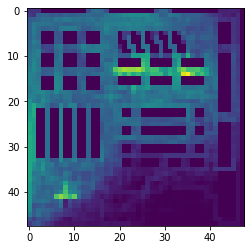

In [38]:
plt.imshow(price_density_grid)

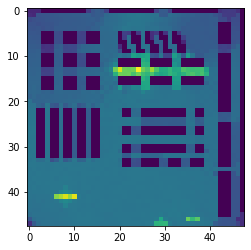

In [39]:
plt.imshow(shopper_density_grid)

In [40]:
total=0
for pdt in pdt_list:
    total += pdt.discounted_price*pdt.qty
    
print("No of products:", len(pdt_list))
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))
print("Total Value", total)
print("Value of Goods bought",fig_1_layout_object.value_of_goods_bought )
print("Total Loss:", total_loss(shopper_density_grid, price_density_grid))

No of products: 134
Number of products in layout: 0
Total Value 776416.13
Value of Goods bought 776416.1299999894
Total Loss: 775603.0


In [26]:
for pdt in pdt_list:
    if pdt.index == 114:
        print(pdt.qty)

1
